In [1]:
library(mmge)
library(expm)
library(fields)
library(scales)
library(MASS)

Loading required package: Matrix


Attaching package: ‘expm’


The following object is masked from ‘package:Matrix’:

    expm


Loading required package: spam

Spam version 2.9-1 (2022-08-07) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following object is masked from ‘package:Matrix’:

    det


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


Loading required package: viridis

Loading required package: viridisLite


Try help(fields) to get started.


Attaching package: ‘scales’


The following object is masked from ‘package:viridis’:

    viridis_pal




In [2]:
devtools::reload(pkg=".")

Reloading attached mmge



# 0. Load data from MAT files

In [3]:
library(R.matlab)

R.matlab v3.7.0 (2022-08-25 21:52:34 UTC) successfully loaded. See ?R.matlab for help.


Attaching package: ‘R.matlab’


The following objects are masked from ‘package:base’:

    getOption, isOpen




In [4]:
data_dir = '~/_datasets/Smith_LFPs_raw/'

In [5]:
data_names = list('Pe160503', 'Pe160505', 'Pe160506',
                  'Pe160507', 'Pe160508')

In [6]:
t0 = 251; t1 = 500

In [7]:
map = readMat(paste0(data_dir,'maps.mat'))$map[[1]]

In [8]:
data = lapply(data_names, function(dname){
    return(aperm(
        readMat(paste0(data_dir,dname,'_lfp.mat'))$pfc[,t0:t1,],
        c(2,3,1)))
})

In [9]:
# save(data, map, file='Smith_LFPs_pfc_delay1.RData')

# 1. load data

In [23]:
load('Smith_LFPs_pfc_delay1.RData')

In [24]:
data = lapply(data, function(d){
    return(d[seq(1,dim(d)[1],5),,])
})

In [25]:
data = lapply(data, function(d){
    mean_d = apply(d, c(1,2), mean)
    std_d = apply(d, c(1,2), sd)
    return((d-c(mean_d))/c(std_d))
})

In [26]:
m = length(data)
p = dim(data[[1]])[1]
q = dim(data[[1]])[2]

In [27]:
c(m, p, q)

[1]  5 50 96

In [28]:
ns = unlist(lapply(data, function(x){dim(x)[3]}))

In [30]:
ns

[1] 2000 2996 3000 3000 3000

In [29]:
sess.id = unlist(lapply(1:m, function(l){rep(l,ns[l])}))

# 1. estimation

In [36]:
ld = 1e-2

In [63]:
est.T = est.temporal(data, order.T=5)

In [ ]:
est.S = est.spatial(data, lambdas=1e-2, verbose=TRUE)

In [ ]:
inf.S = inf.single.edge(est.S$W.hat.S, est.T$S.hat.T, ns)

In [70]:
# save(est.T, est.S, inf.S, file='result_pfc_delay1.RData')

# 2. connectivity strength vs. distance

In [110]:
dists = matrix(0, nrow=q*(q-1)/2)
ps =  matrix(0, nrow=q*(q-1)/2)

In [112]:
k=1
for (i in 1:(q-1)){
    for (j in (i+1):q){
        pos1 = which(map==i, arr.ind = T)
        pos2 = which(map==j, arr.ind = T)
        
        dists[k] = sqrt((pos1[1]-pos2[1])^2+(pos1[2]-pos2[2])^2)*400
        ps[k] = abs(inf.S$T.hat[i,j,1]/sum(sqrt(ns*p/m)))
        
        k = k+1
    }
}

In [113]:
uds = sort(unique(dists))
meanps = matrix(0, nrow=length(uds), ncol=1)
nsamples = matrix(0, nrow=length(uds), ncol=1)
for (i in 1:length(uds)){
    ud = uds[i]
    ids = which(dists==ud, arr.ind = T)
    
    meanps[i] = mean(abs(ps[ids]))
    nsamples[i] = sum(dim(ids)[1])
}

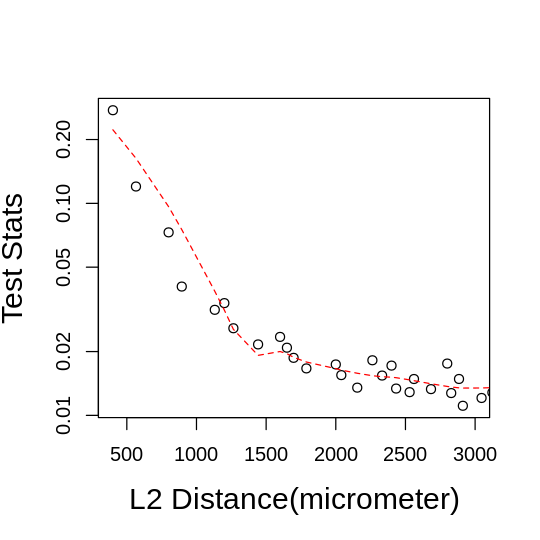

In [115]:
plot(uds, (meanps), xlim = c(400, 3000), log='y', xlab = 'L2 Distance(micrometer)', ylab = 'Test Stats', cex.lab=1.5, lwd=1)
lo <- loess(meanps~uds, span = 0.4)
lines(uds,predict(lo), col='red', lwd=1, lty=2)

# 3. connectivity strength heatmap

In [80]:
maps_amp = matrix(NA, nrow=10*11, ncol=10*11)

In [88]:
for(i in 1:q){
    amp = sum(abs(inf.S$T.hat[i,,1]/sum(sqrt(ns*p/m))))-1
    ind = which(map==i, arr.ind=TRUE)
    maps_amp[ind[1]*10, ind[2]*10] = amp
}

In [94]:
is = image.smooth(maps_amp, theta=10)
is$x = is$x[10:100]
is$y = is$y[10:100]
is$z = is$z[10:100,10:100]
is$x = 40*(is$x-10)
is$y = 40*(is$y-10)

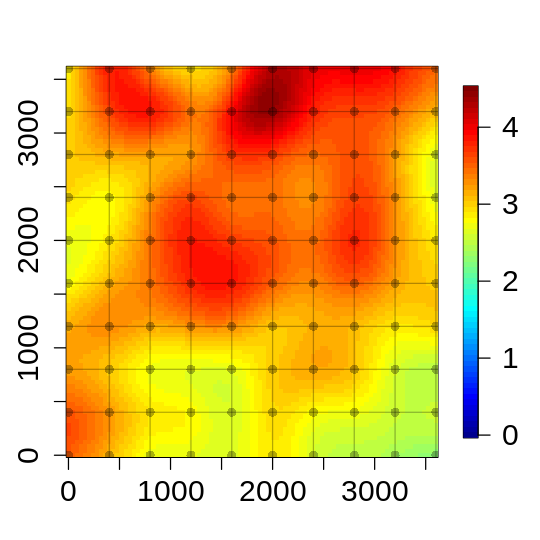

In [109]:
par(cex.axis=1.5)
image.plot(is, zlim=c(0,4.5))
for (i in 1:10){
  for (j in 1:10){
    points((i-1)*400, (j-1)*400, pch=16, lwd=0.5, col=alpha('black',0.3))
  }
  abline(h =i*400,, col=alpha('black',0.3))
  abline(v =i*400,, col=alpha('black',0.3)) 
}